In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SEED = 1097
rng = np.random.default_rng(SEED)
az.style.use("arviz-darkgrid")

In [3]:
alpha, sigma = 3, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Text(0.5, 0, 'X2')

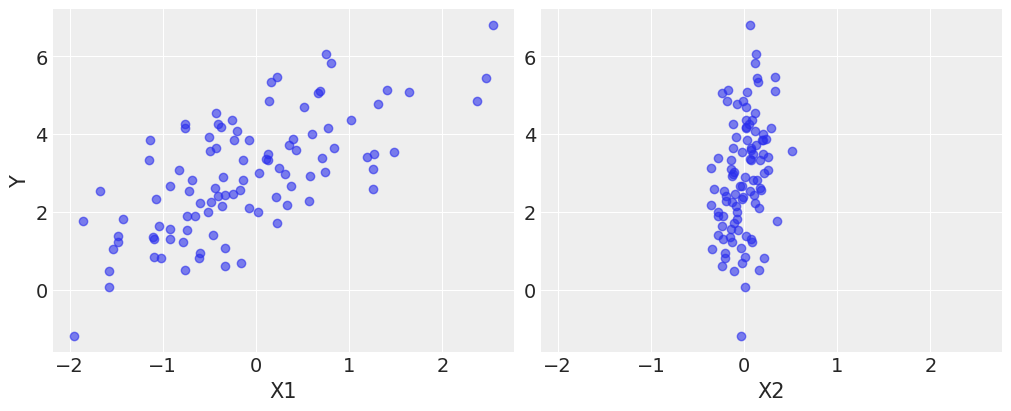

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel('Y')
axes[0].set_xlabel('X1')
axes[1].set_xlabel('X2')

In [5]:
import pymc as pm

In [6]:
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = alpha + beta[0] * X1 + beta[1] * X2

    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [7]:
with basic_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[2.92547188, 3.14318934, 3.00587841, 3.13603871, 3.06760625],
       [3.21063792, 2.90523304, 3.2390241 , 3.27994133, 2.91308194],
       [3.0880344 , 3.0880344 , 3.03656159, 3.11511258, 2.95702193],
       [3.29676203, 2.876254  , 3.12724878, 3.06738487, 3.02533565]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

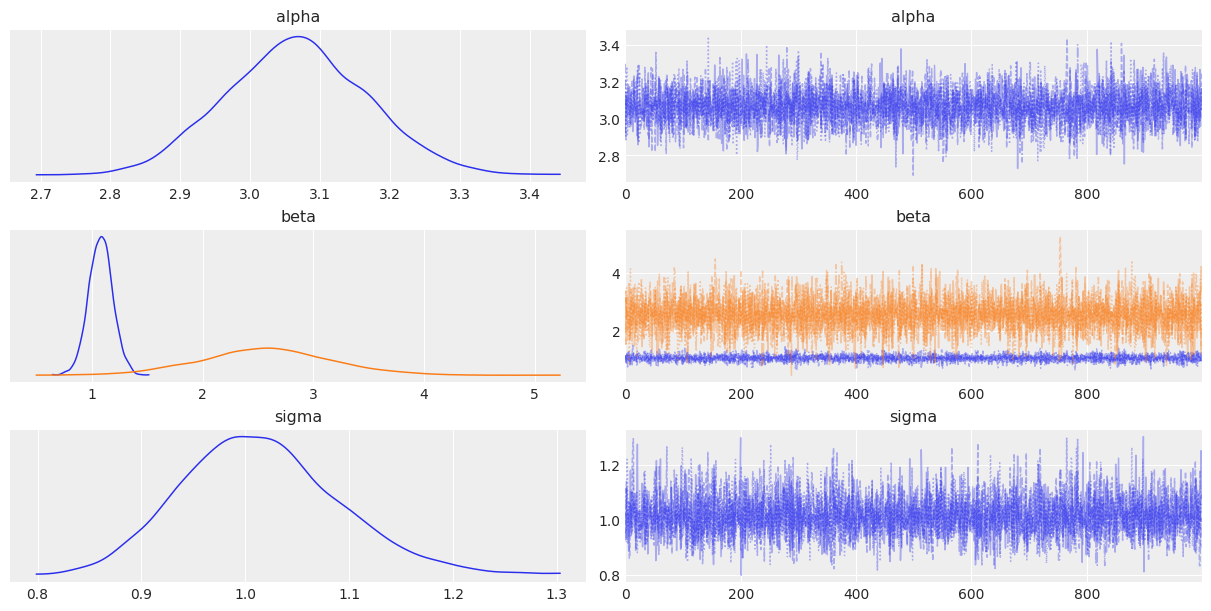

In [10]:
az.plot_trace(idata, combined=True)

In [11]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.07,0.10,2.88,3.25,0.00,0.00,4983.47,2936.77,1.0
beta[0],1.08,0.11,0.87,1.28,0.00,0.00,5399.75,3240.01,1.0
beta[1],2.57,0.59,1.42,3.64,0.01,0.01,6391.17,3090.54,1.0
sigma,1.02,0.08,0.88,1.16,0.00,0.00,6002.86,3325.83,1.0


# GP

In [15]:
X = np.column_stack((X1, X2))

In [40]:
with pm.Model() as gpmod:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfCauchy("eta", beta=5)

    cov = eta**2 * pm.gp.cov.Matern52(2, ell)
    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfCauchy("sigma", beta=5)
    y = gp.marginal_likelihood("y", X=X, y=Y, sigma=sigma)

In [41]:
with gpmod:
    marginal_post = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 39 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'ell'}>, <Axes: title={'center': 'ell'}>],
       [<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

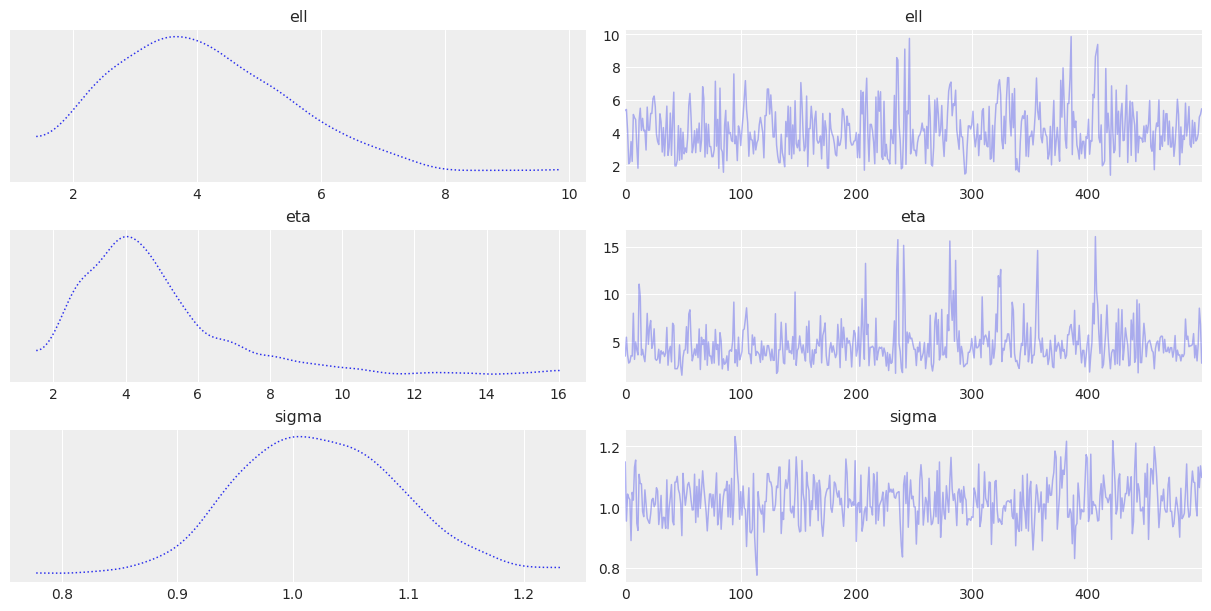

In [42]:
az.plot_trace(marginal_post, combined=True)

In [19]:
X3 = np.random.randn(size)
X4 = np.random.randn(size) * 0.2
X_new = np.column_stack((X3,X4))

In [20]:
with gpmod:
    f_pred = gp.conditional("f_pred", X_new)

with gpmod:
    pred_samples = pm.sample_posterior_predictive(
        marginal_post.sel(draw=slice(0,20)), var_names=["f_pred"]
    )

Sampling: [f_pred]


In [21]:
from pymc.gp.util import plot_gp_dist

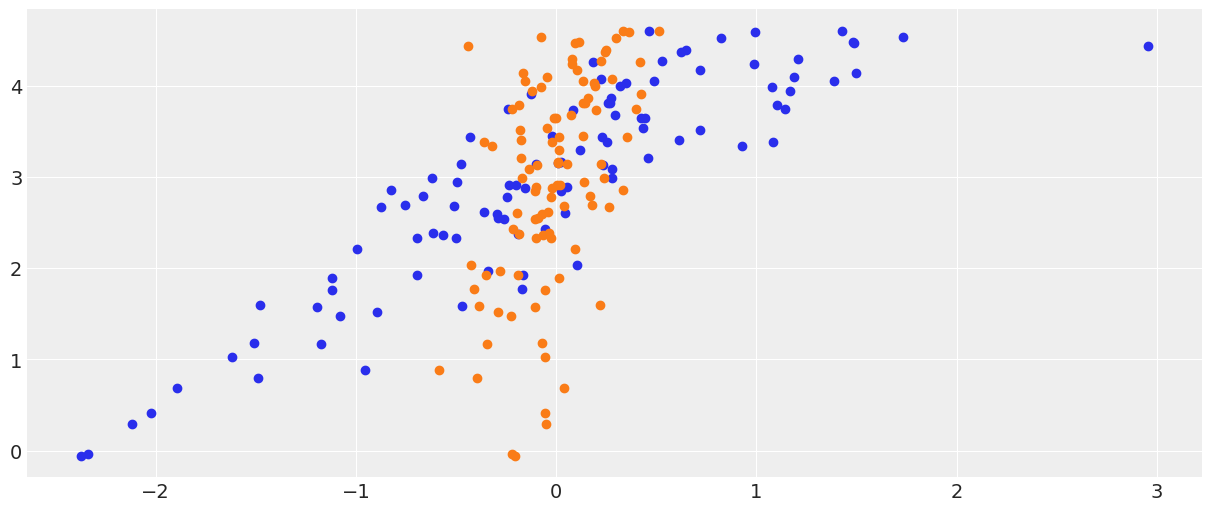

In [29]:
# predict
with gpmod:
    mu, var = gp.predict(
        X_new, point=az.extract(marginal_post.posterior.sel(draw=[0])).squeeze(), diag=True
    )
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2sigma intervals
plt.scatter(X_new[:,0], mu) #, "r", lw=2, label="mean and 2σ region")
plt.scatter(X_new[:,1], mu) #, "r", lw=2, label="mean and 2σ region")
# plt.scatter(X_new[:,0], mu) + 2 * sd, "r", lw=1)
# plt.scatter(X_new[:,0], mu) - 2 * sd, "r", lw=1)
#plt.fill_between(X_new.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, "ok", ms=3, alpha=1.0, label="observed data")
#plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

#plt.xlabel("x")
#plt.ylim([-13, 13])
#plt.title("predictive mean and 2sigma interval")
#plt.legend();

In [49]:
back_model = pm.Model()

with gpmod:
    xc = pm.Normal("xc", mu=0, sigma=10)
    g = gp.predict("g", xc[:,None])
    

IndexError: too many indices for array